# Facial Recognition System Using Transfer Learning with MobileNetV2

# Step 1: Install Libraries

In [6]:
# Install TensorFlow and OpenCV for deep learning and image processing
!pip install tensorflow opencv-python-headless

# Step 2: Import Libraries

In [7]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Step 3: Load and Preprocess Dataset

In [10]:
# This dataset contains images of faces with labels for facial recognition tasks.
lfw_dataset = fetch_lfw_people(min_faces_per_person=200, resize=0.5)

In [11]:
# Extract features and labels
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names  # Names of individuals (classes)

# Normalize images to the range [0, 1]
X = X / 255.0

# Resize grayscale images to 3-channel RGB images (required for MobileNetV2)
X = np.stack([cv2.resize(cv2.cvtColor(img.astype('float32'), cv2.COLOR_GRAY2RGB), (128, 128)) for img in X])

# One-hot encode the labels for multi-class classification
y_encoded = to_categorical(y, num_classes=len(target_names))

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X)} images, {len(target_names)} classes.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Dataset loaded: 766 images, 2 classes.
Training data shape: (612, 128, 128, 3)
Validation data shape: (154, 128, 128, 3)


# Step 4: Build the Model

In [12]:
# Load the MobileNetV2 base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze the entire base model

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Remove L2 regularization
    layers.Dropout(0.3),  # Reduce dropout
    layers.Dense(len(target_names), activation='softmax')  # Number of classes in the dataset
])

# Compile the model with a higher learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Data Augmentation

In [13]:
# Create a data generator for augmenting the training data
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images by up to 15 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10%
    height_shift_range=0.1,  # Shift images vertically by up to 10%
    shear_range=0.1,  # Shear images
    zoom_range=0.1,  # Zoom images in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill any empty pixels after augmentation
)
datagen.fit(X_train)

# Step 6: Train the Model

In [14]:
# Add callbacks for training optimization
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop training early if validation loss doesn't improve
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)  # Reduce learning rate when the validation loss plateaus
]

# Train the model using augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6446 - loss: 0.6724 - val_accuracy: 0.7013 - val_loss: 0.6251 - learning_rate: 1.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9389 - loss: 0.1967 - val_accuracy: 0.7013 - val_loss: 0.6208 - learning_rate: 1.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9637 - loss: 0.1334 - val_accuracy: 0.2987 - val_loss: 0.7126 - learning_rate: 1.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9892 - loss: 0.0598 - val_accuracy: 0.7013 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9822 - loss: 0.0544
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9821 - loss: 0.0547 - val_accuracy: 0.7013 - val_loss: 0.6891 - learning_rate: 1.0000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9932 - loss: 0.02

# Step 7: Visualize Training Results

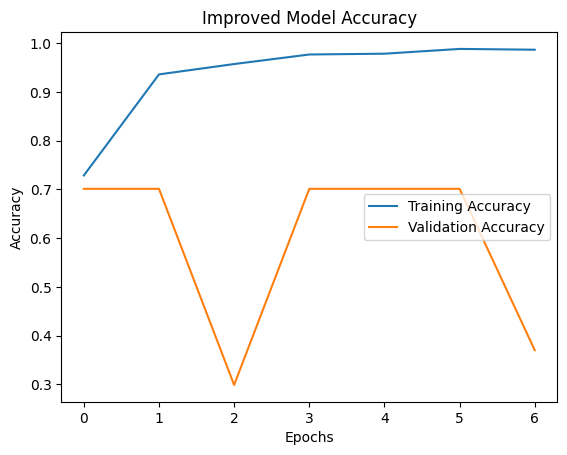

In [15]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Improved Model Accuracy')
plt.show()


# Step 8: Evaluate the Model

In [16]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.6986 - loss: 0.6221
Validation Loss: 0.6207525134086609
Validation Accuracy: 0.701298713684082


# Step 9: Save the Model

In [17]:
# Save the trained model for future use
model.save('facial_recognition_model.h5')
print("Model saved as 'facial_recognition_model.h5'")


Model saved as 'facial_recognition_model.h5'
